In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 

In [3]:
import functools
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import pnstyler.styler as styler
import ml_confs

In [4]:
configs = ml_confs.from_dict({
    'train_samples': 10000,
    'test_samples': 100,
})

In [5]:
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation

In [6]:
from kooplearn.datasets import Lorenz63, LogisticMap

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples + 1000 + configs.test_samples)
#raw_data = LogisticMap(N=20).sample(X0 = np.ones(1), T=configs.train_samples + 1000 + configs.test_samples)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

train_data = data[:configs.train_samples + 1]
test_data =  data[-configs.test_samples - 1:]

## Estimator fitting

In [7]:
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import pdist
from kooplearn.models import KernelDMD
from kooplearn.models import NystroemKernel
from kooplearn.data import traj_to_contexts

# Length scale of the kernel: median of the pairwise distances of the dataset
data_pdist = pdist(train_data)
kernel = RBF(length_scale=np.quantile(data_pdist, 0.5))
train_contexts = traj_to_contexts(train_data)
test_contexts = traj_to_contexts(test_data)

In [8]:
def runner(models, stop):
    results = {}
    for name, model in models.items():
        print(f'{name}')
        model, fit_time = timer(model.fit)(train_contexts[:stop], verbose=False)
        # One-step prediction
        X_pred = model.predict(test_contexts[:, :-1, ...])
        X_true = test_contexts[:, 1, ...]
        # Eigenvalues
        eigs = model.eig()

        results[name] = {
            'model': model,
            'fit_time': fit_time,
            'train_risk': model.risk(),
            'rMSE_onestep': np.sqrt(np.mean((X_pred - X_true)**2)),
            'eigenvalues': eigs,
        }
    return results
    
def hausdorff_distance(eigs_1, eigs_2):
    dist = np.abs(eigs_1[:, None] - eigs_2[None, :])
    d1 = np.min(dist, axis=1).max()
    d2 = np.min(dist, axis=0).max()
    return max(d1, d2)

## Benchmarking

In [9]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

In [10]:
train_stops = np.logspace(3, 4, 10).astype(int)
results = []
for stop in train_stops:
    models = {
        'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
        'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=5),
        'Nystroem': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
    }
    print(f'\n\nTraining points: {stop}')
    results.append(runner(models, stop))



Training points: 100
KernelDMD


RandSVDKernelDMD
Nystroem


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.




Training points: 129
KernelDMD
RandSVDKernelDMD
Nystroem


The rank attribute has been updated to 24.
Consider decreasing the rank parameter.




Training points: 166
KernelDMD
RandSVDKernelDMD


Nystroem


The rank attribute has been updated to 22.
Consider decreasing the rank parameter.




Training points: 215
KernelDMD


RandSVDKernelDMD


Nystroem


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.




Training points: 278
KernelDMD
RandSVDKernelDMD
Nystroem


The rank attribute has been updated to 21.
Consider decreasing the rank parameter.




Training points: 359
KernelDMD
RandSVDKernelDMD
Nystroem


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.




Training points: 464
KernelDMD


RandSVDKernelDMD
Nystroem


The rank attribute has been updated to 24.
Consider decreasing the rank parameter.




Training points: 599
KernelDMD
RandSVDKernelDMD
Nystroem


Training points: 774
KernelDMD
RandSVDKernelDMD
Nystroem


Training points: 1000
KernelDMD
RandSVDKernelDMD
Nystroem


In [11]:
timings = {name: [res[name]['fit_time'] for res in results] for name in models.keys()}
rMSE = {name: [res[name]['rMSE_onestep'] for res in results] for name in models.keys()}

In [12]:
styler.set_color_palette('categorical_dark')

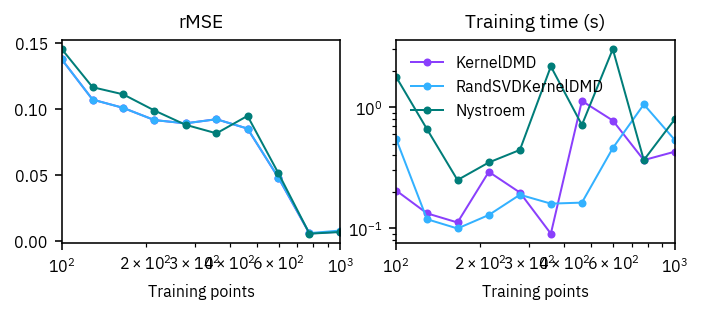

In [13]:

fig, axes = plt.subplots(ncols=2, figsize=styler.figsize(width_to_height=3), dpi=144)
for name in models.keys():
    axes[0].plot(train_stops, rMSE[name], '.-', label=name)
    axes[1].plot(train_stops, timings[name], '.-', label=name)

axes[0].set_title('rMSE')
axes[1].set_title('Training time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')
for ax in axes:
    ax.set_xscale('log')
    
    ax.set_xlabel('Training points')